# cVAE with Dictionary Learning

In [1]:
# Setup & Imports
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.utils import save_image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from data_loader import PadChestDataset
from models.vae_dict import cVAE_Dict
from train import train_epoch, onehot

In [2]:
# Load Data
# dataset = PadChestDataset(path="data/dataset_small.pkl")
dataset = PadChestDataset(path="../data/dataset_small.pkl")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Instantiate Model
cond_dim = 2       # PA vs AP
# code_dim = 64
code_dim = 128
dict_dim = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cVAE_Dict(dict_dim=dict_dim, code_dim=code_dim, cond_dim=cond_dim).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# lambda_sparse = 0.1
# increasing to:
lambda_sparse = 1e-2  # 5e-2

Epoch 01 | Loss: 0.0247
Epoch 30 | Loss: 0.0242
Epoch 60 | Loss: 0.0239
Epoch 90 | Loss: 0.0236
Epoch 120 | Loss: 0.0233
Epoch 150 | Loss: 0.0231
Epoch 180 | Loss: 0.0229
Epoch 210 | Loss: 0.0227
Epoch 240 | Loss: 0.0226
Epoch 270 | Loss: 0.0225
Epoch 300 | Loss: 0.0224
Dataset length after filtering: 7
Running full model analysis and export pipeline...


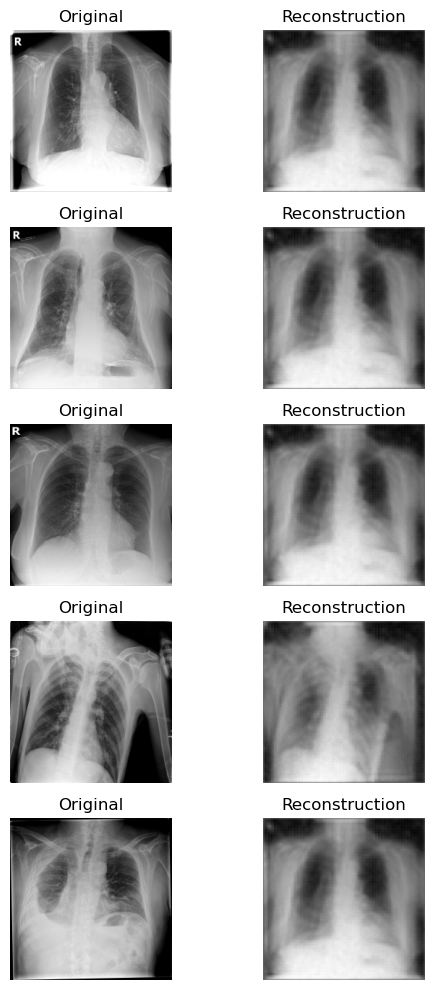

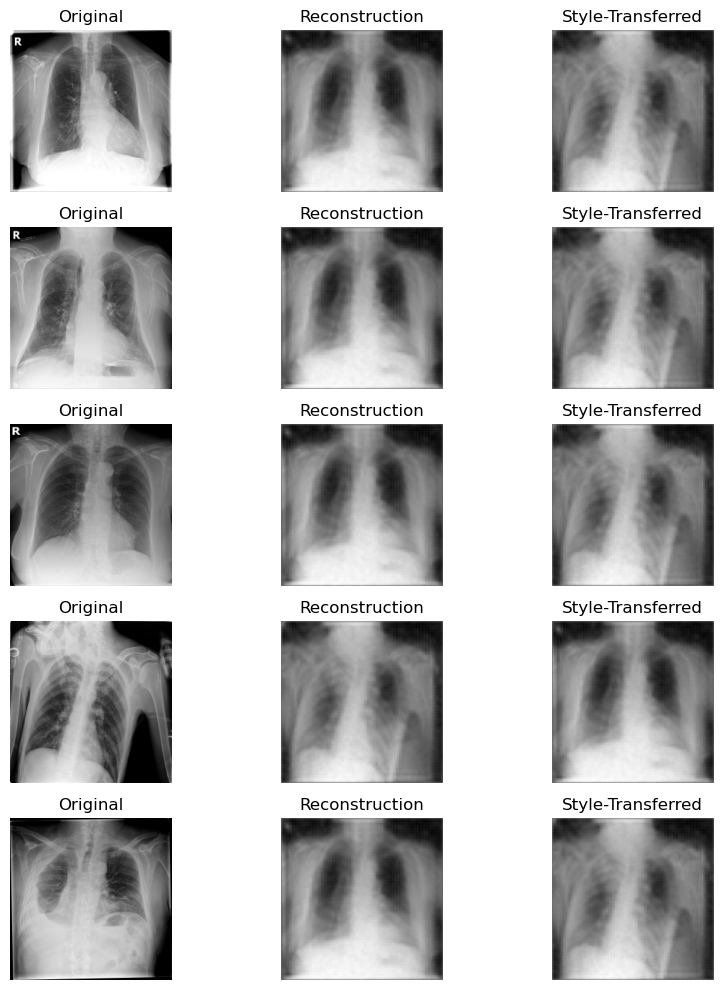

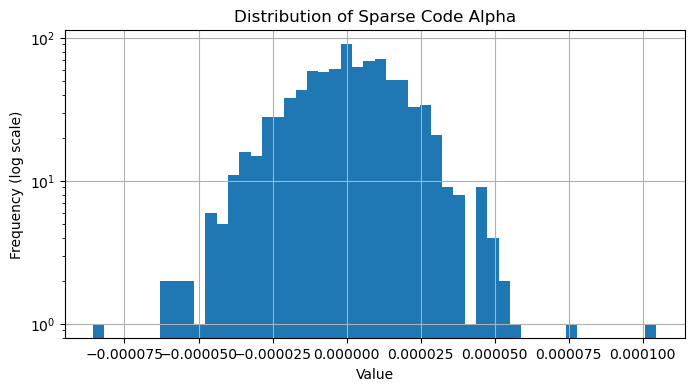

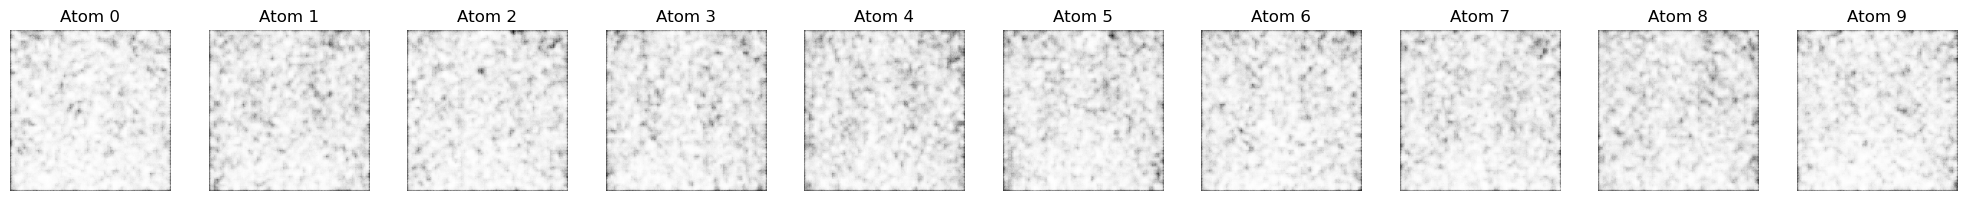

Latent space classification accuracy (PA vs AP): 0.571
Saved alpha vectors and labels to outputs/alphas/


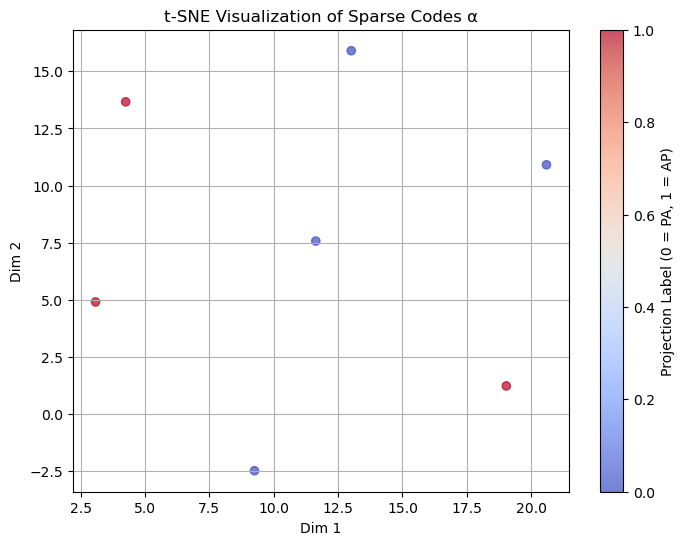

Full analysis pipeline complete.


In [ ]:
# Training Loop with Early Stopping and Sparse Logging
best_loss = float("inf")
patience = 50
epochs_no_improve = 0
max_epochs = 300

for epoch in range(1, max_epochs + 1):
    loss = train_epoch(model, dataloader, optimizer, lambda_sparse, device)


    if epoch % (max_epochs // 10) == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Loss: {loss:.4f}")
    
    if loss < best_loss:
        best_loss = loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch:02d}")
        break



# Reconstruction Visualization
def visualize_reconstruction(model, dataset, n=5):
    n = min(n, len(dataset))
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(n, 2, figsize=(6, 2*n))
        for i in range(n):
            sample = dataset[i]
            x = sample["image"].unsqueeze(0).to(device)
            cond = onehot(sample["cond"].unsqueeze(0).to(device), 2)
            x_hat, _ = model(x, cond, cond)
            axs[i, 0].imshow(x.squeeze().cpu(), cmap="gray")
            axs[i, 0].set_title("Original")
            axs[i, 1].imshow(x_hat.squeeze().cpu(), cmap="gray")
            axs[i, 1].set_title("Reconstruction")
            for ax in axs[i]:
                ax.axis("off")
        plt.tight_layout()
        plt.show()

# Style Transfer Visualization (e.g., AP to PA)
def visualize_style_transfer(model, dataset, n=5):
    n = min(n, len(dataset))
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(n, 3, figsize=(9, 2*n))
        for i in range(n):
            sample = dataset[i]
            x = sample["image"].unsqueeze(0).to(device)
            cond_src = sample["cond"]
            cond_tgt = 1 - cond_src
            c_src = onehot(torch.tensor([cond_src], device=device), 2)
            c_tgt = onehot(torch.tensor([cond_tgt], device=device), 2)

            x_hat_recon, _ = model(x, c_src, c_src)
            x_hat_transfer, _ = model(x, c_src, c_tgt)

            axs[i, 0].imshow(x.squeeze().cpu(), cmap="gray")
            axs[i, 0].set_title("Original")
            axs[i, 1].imshow(x_hat_recon.squeeze().cpu(), cmap="gray")
            axs[i, 1].set_title("Reconstruction")
            axs[i, 2].imshow(x_hat_transfer.squeeze().cpu(), cmap="gray")
            axs[i, 2].set_title("Style-Transferred")
            for ax in axs[i]:
                ax.axis("off")
        plt.tight_layout()
        plt.show()

# Latent Sparsity Analysis
def plot_sparsity_histogram(model, dataset, n=100):
    n = min(n, len(dataset))
    model.eval()
    alphas = []
    with torch.no_grad():
        for i in range(n):
            sample = dataset[i]
            x = sample["image"].unsqueeze(0).to(device)
            cond = onehot(sample["cond"].unsqueeze(0).to(device), 2)
            _, alpha = model(x, cond, cond)
            alphas.append(alpha.squeeze().cpu())
    alphas = torch.stack(alphas)
    plt.figure(figsize=(8,4))
    plt.hist(alphas.flatten(), bins=50, log=True)
    plt.title("Distribution of Sparse Code Alpha")
    plt.xlabel("Value")
    plt.ylabel("Frequency (log scale)")
    plt.grid(True)
    plt.show()

# Dictionary Atom Visualization
def visualize_dictionary_atoms(model, num_atoms=10):
    num_atoms = min(num_atoms, model.dictionary.shape[0])
    with torch.no_grad():
        fig, axs = plt.subplots(1, num_atoms, figsize=(2 * num_atoms, 2))
        for i in range(num_atoms):
            alpha = torch.zeros((1, model.dictionary.shape[0]))  # [1, dict_dim]
            alpha[0, i] = 1.0  # activate only the i-th atom

            z = torch.matmul(alpha, model.dictionary)  # [1, code_dim]
            cond_dummy = torch.zeros((1, 2))  # neutral condition
            out = model.decoder(z, cond_dummy).squeeze().numpy()

            axs[i].imshow(out, cmap="gray")
            axs[i].set_title(f"Atom {i}")
            axs[i].axis("off")
        plt.tight_layout()
        plt.show()



# Disentanglement Classifier
def evaluate_latent_style_classification(model, dataset, n=300):
    n = min(n, len(dataset))
    model.eval()
    alphas, labels = [], []
    with torch.no_grad():
        for i in range(n):
            sample = dataset[i]
            x = sample["image"].unsqueeze(0).to(device)
            cond = onehot(sample["cond"].unsqueeze(0).to(device), 2)
            _, alpha = model(x, cond, cond)
            alphas.append(alpha.squeeze().cpu().numpy())
            labels.append(sample["cond"])

    clf = LogisticRegression(max_iter=1000).fit(alphas, labels)
    preds = clf.predict(alphas)
    acc = accuracy_score(labels, preds)
    print(f"Latent space classification accuracy (PA vs AP): {acc:.3f}")

# Save reconstructions and style-transferred images
def save_images(model, dataset, n=20):
    n = min(n, len(dataset))
    os.makedirs("outputs/reconstructions", exist_ok=True)
    os.makedirs("outputs/transfers", exist_ok=True)
    model.eval()
    with torch.no_grad():
        for i in range(n):
            sample = dataset[i]
            x = sample["image"].unsqueeze(0).to(device)
            cond_src = sample["cond"]
            cond_tgt = 1 - cond_src
            c_src = onehot(torch.tensor([cond_src], device=device), 2)
            c_tgt = onehot(torch.tensor([cond_tgt], device=device), 2)

            x_hat, _ = model(x, c_src, c_src)
            x_transfer, _ = model(x, c_src, c_tgt)

            save_image(x_hat, f"outputs/reconstructions/recon_{i:03d}.png")
            save_image(x_transfer, f"outputs/transfers/transfer_{i:03d}.png")

# Save latent alpha vectors
def save_alpha_vectors(model, dataset, n=300):
    n = min(n, len(dataset))
    os.makedirs("outputs/alphas", exist_ok=True)
    model.eval()
    alpha_list = []
    label_list = []
    with torch.no_grad():
        for i in range(n):
            sample = dataset[i]
            x = sample["image"].unsqueeze(0).to(device)
            cond = onehot(sample["cond"].unsqueeze(0).to(device), 2)
            _, alpha = model(x, cond, cond)
            alpha_list.append(alpha.squeeze().cpu().numpy())
            label_list.append(sample["cond"])

    np.save("outputs/alphas/alpha_vectors.npy", np.array(alpha_list))
    np.save("outputs/alphas/alpha_labels.npy", np.array(label_list))
    print("Saved alpha vectors and labels to outputs/alphas/")

# Load and visualize saved alpha vectors
def load_and_visualize_alphas():
    alphas = np.load("outputs/alphas/alpha_vectors.npy")
    labels = np.load("outputs/alphas/alpha_labels.npy")
    # pca = PCA(n_components=30).fit_transform(alphas)
    # pca = PCA(n_components=min(7, alphas.shape[0], alphas.shape[1])).fit_transform(alphas)
    max_components = min(7, len(alphas), alphas.shape[1])
    pca = PCA(n_components=max_components).fit_transform(alphas)

    # tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(pca)
    adjusted_perplexity = min(30, len(alphas) - 1)
    tsne = TSNE(n_components=2, perplexity=adjusted_perplexity, random_state=42).fit_transform(pca)


    plt.figure(figsize=(8, 6))
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
    plt.colorbar(label="Projection Label (0 = PA, 1 = AP)")
    plt.title("t-SNE Visualization of Sparse Codes α")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()

# Run all analysis
def run_full_analysis(model, dataset):
    print("Running full model analysis and export pipeline...")
    visualize_reconstruction(model, dataset)
    visualize_style_transfer(model, dataset)
    plot_sparsity_histogram(model, dataset)
    visualize_dictionary_atoms(model)
    evaluate_latent_style_classification(model, dataset)
    save_images(model, dataset)
    save_alpha_vectors(model, dataset)
    load_and_visualize_alphas()
    print("Full analysis pipeline complete.")

# Execute everything
print(f"Dataset length after filtering: {len(dataset)}")

run_full_analysis(model, dataset)

